In [1]:
pip install tldextract

In [2]:
pip install python-whois

In [3]:
# !pip install git+https://github.com/rthalley/dnspython

In [4]:
from tldextract import extract
import ssl
import socket
from bs4 import BeautifulSoup
import urllib.request
import whois
import datetime
from googlesearch import search
import re
# import dnspython

#  1 = OK
#  0 = Suspicious
#  -1 = Phish

def url_having_ip(url): #1
    having_ip=0
    flag=0
    symbol = re.search(r'(((\d)+)\.?)+',url)
    if(symbol!=None):
        having_ip = -1
    else:
        having_ip = 1 
    return(having_ip)

def url_length(url): #2
    length=len(url)
    if(length<54):
        return 1
    elif(54<=length<=75):
        return 0
    else:
        return -1

def url_short(url): #3
    symbol1 = re.search(r'(cutt\.ly|bit\.ly|tinyurl\.com)+',url)
    if(symbol1!=None):
        return -1
    else:
        return 1 

def having_at_symbol(url): #4
    symbol=re.findall(r'@',url)
    if(len(symbol)==0):
        return 1
    else:
        return -1 
    
def doubleSlash(url): #5
    if(url.find("//", 8)!=-1):
        return -1
    else:
        return 1

def prefix_Suffix(url): #6
    SubDom, Dom, Suffix = extract(url)
    if(Dom.count('-')):
        return -1
    else:
        return 1

def sub_Dom(url): #7
    SubDom, Dom, Suffix = extract(url)
    if(SubDom.count('.')==0):
        return 1
    elif(SubDom.count('.')==1):
        return 0
    else:
        return -1

def SSLfinal_State(url): #8
    try:    
        if(re.search('https',url)):
            usehttps = 1
        else:
            usehttps = 0
#===============================================================================================================================================================================================================================================================================
        SubDom, Dom, Suffix = extract(url)
        host_name = Dom + "." + Suffix
        context = ssl.create_default_context()
        sct = context.wrap_socket(socket.socket(), server_hostname = host_name)
        sct.connect((host_name, 443))
        certificate = sct.getpeercert()
        issuer = dict(x[0] for x in certificate['issuer'])
        certificate_Auth = str(issuer['commonName'])
        certificate_Auth = certificate_Auth.split()
        if(certificate_Auth[0] == "Network" or certificate_Auth == "Deutsche"):
            certificate_Auth = certificate_Auth[0] + " " + certificate_Auth[1]
        else:
            certificate_Auth = certificate_Auth[0]       
        trusted_Auth = ['Comodo','Symantec','GoDaddy','GlobalSign','DigiCert','Sectigo','StartCom','Entrust','Verizon','Trustwave','Unizeto','Buypass','QuoVadis','Deutsche Telekom','Network Solutions','SwissSign','IdenTrust','Secom','TWCA','GeoTrust','Thawte','Doster','VeriSign', 'GTS']
        startingDate = str(certificate['notBefore'])
        endingDate = str(certificate['notAfter'])
        startingYear = int(startingDate.split()[3])
        endingYear = int(endingDate.split()[3])
        Age_of_certificate = endingYear-startingYear
#===============================================================================================================================================================================================================================================================================
        
        if((usehttps==1) and (certificate_Auth in trusted_Auth) and (Age_of_certificate>=1) ):
            return 1 
        
        elif((usehttps==1) and (certificate_Auth not in trusted_Auth)):
            return 0 
        elif(certificate_Auth == 'GTS'):
            return 1
        else:
            return -1 
                
    except Exception as e:
        return -1

def Dom_registration(url): #9
    try:
        w = whois.whois(url)
        updated = w.updated_date
        exp = w.expiration_date
        if(isinstance(exp, list)):
            exp=exp[0]
        if(isinstance(updated, list)):
            updated=updated[0]
        length = (exp-updated).days
        if(length<=365):
            return -1
        else:
            return 1
    except Exception as e:
        return 0

def https_token(url): #10
    if(url.find("https")!=-1): 
        return 1
    else:
        return -1

def request_url(url): #11
    try:
        SubDom, Dom, Suffix = extract(url)
        websiteDom = Dom
        
        opener = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(opener, 'lxml')
        imgs = soup.findAll('img', src=True)
        total = len(imgs)
        
        linked_to_same = 0
        avg =0
        for image in imgs:
            SubDom, Dom, Suffix = extract(image['src'])
            imageDom = Dom
            if(websiteDom==imageDom or imageDom==''):
                linked_to_same = linked_to_same + 1
        vids = soup.findAll('video', src=True)
        total = total + len(vids)
        
        for video in vids:
            SubDom, Dom, Suffix = extract(video['src'])
            vidDom = Dom
            if(websiteDom==vidDom or vidDom==''):
                linked_to_same = linked_to_same + 1
                
        linked_outside = total-linked_to_same
        if(total!=0):
            avg = linked_outside/total
            
        if(avg<0.22):
            return 1
        elif(0.22<=avg<=0.61):
            return 0
        else:
            return -1
    except Exception as e:
        return 0


def url_of_anchor(url): #12
    try:
        SubDom, Dom, Suffix = extract(url)
        websiteDom = Dom
        
        opener = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(opener, 'lxml')
        anchors = soup.findAll('a', href=True)
        total = len(anchors)
        linked_to_same = 0
        avg = 0
        for anchor in anchors:
            SubDom, Dom, Suffix = extract(anchor['href'])
            anchorDom = Dom
            if(websiteDom==anchorDom or anchorDom==''):
                linked_to_same = linked_to_same + 1
        linked_outside = total-linked_to_same
        if(total!=0):
            avg = linked_outside/total
            
        if(avg<0.31):
            return 1
        elif(0.31<=avg<=0.67):
            return 0
        else:
            return -1
    except Exception as e:
        return 0
    
    
def Links_in_tags(url): #13
    try:
        opener = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(opener, 'lxml')
        
        no_of_meta =0
        no_of_link =0
        no_of_script =0
        anchors=0
        avg =0
        
        for meta in soup.find_all('meta'):
            no_of_meta = no_of_meta+1
        for link in soup.find_all('link'):
            no_of_link = no_of_link +1
        for script in soup.find_all('script'):
            no_of_script = no_of_script+1
        for anchor in soup.find_all('a'):
            anchors = anchors+1
        
        total = no_of_meta + no_of_link + no_of_script+anchors
        tags = no_of_meta + no_of_link + no_of_script
        
        if(total!=0):
            avg = tags/total

        if(avg<0.17):
            return 1
        elif(0.17<=avg<=0.81):
            return 0
        else:
            return -1        
    except Exception as e:  
        return 0

def email_submit(url): #14
    try:
        opener = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(opener, 'lxml')
        if(soup.find('mailto:')):
            return -1
        else:
            return 1 
    except:
        return 0

def age_of_Dom(url): #15
    try:
        Stats = whois.whois(url)
        start_date = Stats.creation_date
        current_date = datetime.datetime.now()
        if(isinstance(start_date, list)):
            start_date=start_date[0]
        if(isinstance(current_date, list)):
            current_date=current_date[0]
        age =(current_date-start_date).days
        if(age>=180):
            return 1
        else:
            return -1
    except Exception as e:
        return 0
        
# def dns(url):
#     print(dnspython.Resolver.query(url, 'A'))
#     return 0

def web_traffic(url): #16
    try:
        rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find("REACH")['RANK']
    except TypeError:
        return -1
    rank = int(rank)
    if (rank < 100000):
        return 1
    else:
        return 0

def google_index(url): #17
    try:
        site = search(url)
        return 1 if site else -1
    except:
        return 0

def main(url):  
    check = [[url_having_ip(url),
              url_length(url),
              url_short(url),
              having_at_symbol(url),
              doubleSlash(url),
              prefix_Suffix(url),
              sub_Dom(url),
              SSLfinal_State(url),
              Dom_registration(url),
              https_token(url),
              request_url(url),
              url_of_anchor(url),
              Links_in_tags(url),
              email_submit(url),
              age_of_Dom(url),
              # dns(url),
              web_traffic(url),
              google_index(url)]]

    print(check)
    return check   

## Importing the libraries

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

## Importing and reading the dataset

In [6]:
df = pd.read_csv('dataset1.csv')
df.head()

,index,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,Submitting_to_email,age_of_domain,web_traffic,Google_Index,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,1,-1
1,2,1,1,1,1,1,-1,0,1,-1,-1,1,0,-1,1,-1,0,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,-1,1,0,-1,-1,1,1,1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,-1,-1,0,0,1,-1,1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,1,1,0,0,1,-1,0,1,1


In [7]:
df.columns

Index(['index', 'having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags',
       'Submitting_to_email', 'age_of_domain', 'web_traffic', 'Google_Index',
       'Result'],
      dtype='object')

In [8]:
df = df.drop(columns=['index'])
df.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,Submitting_to_email,age_of_domain,web_traffic,Google_Index,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,1,-1
1,1,1,1,1,1,-1,0,1,-1,-1,1,0,-1,1,-1,0,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,-1,1,0,-1,-1,1,1,1,-1
3,1,0,1,1,1,-1,-1,-1,1,-1,-1,0,0,1,-1,1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,1,0,0,1,-1,0,1,1


 1    6157
-1    4898
Name: Result, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


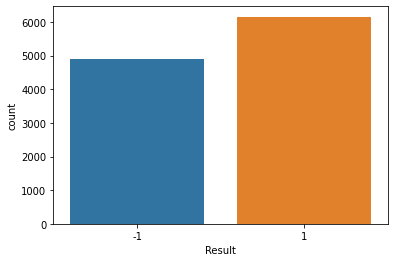

In [9]:
print(df['Result'].value_counts())
sns.countplot(df['Result'])

## Splitting the dataset into the Training set and Test set



In [10]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
print(X)
print("\n",y)

[[-1  1  1 ... -1 -1  1]
 [ 1  1  1 ... -1  0  1]
 [ 1  0  1 ...  1  1  1]
 ...
 [ 1 -1  1 ...  1  1  1]
 [-1 -1  1 ...  1  1  1]
 [-1 -1  1 ... -1 -1 -1]]

 [-1 -1 -1 ... -1 -1 -1]


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Creating and training XGBoost on the Training set

In [27]:
from xgboost import XGBClassifier
classifier = XGBClassifier(booster='gbtree',
                           max_depth = 8,
                           n_estimators=700,
                           learning_rate=0.1,
                           nthread=4)
classifier.fit(X_train, y_train)

XGBClassifier(max_depth=8, n_estimators=700, nthread=4)

## Making the Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 958   56]
 [  32 1165]]


0.9601990049751243

In [29]:
exec = [main("https://www.google.com/"), main("https://kickass.sx/"), main("https://www.netflix.com/in/")]

Error trying to connect to socket: closing socket
Error trying to connect to socket: closing socket
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
[[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]]
Error trying to connect to socket: closing socket
Error trying to connect to socket: closing socket
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 0, 1, 1, 1, 1]]


In [30]:
for value in exec:
  print(classifier.predict(value))
  if(classifier.predict(value) == [1]):
    print("Safe\n")
  else:
    print("Phishing\n")

[1]
Safe

[-1]
Phishing

[1]
Safe

